In [350]:
# Import necessary Libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [351]:
# Load all the data.
bom_movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdb_name_basics_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
imdb_title_akas_df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_title_crew_df = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_title_principals_df = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_title_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [352]:
#renaming it to work on
money_metrics_df = tn_movie_budgets_df

#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

#cleaning
money_metrics_df = clean_a_money_column(money_metrics_df,'worldwide_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'domestic_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'production_budget')

#adding profit margin and ROI columns
money_metrics_df['Profit Margin']= (money_metrics_df['worldwide_gross']-money_metrics_df['production_budget'])/money_metrics_df['worldwide_gross']
money_metrics_df['ROI'] = (money_metrics_df['worldwide_gross']/money_metrics_df['production_budget'])

#creating year and month columns
money_metrics_df['Year'] = money_metrics_df['release_date']


#Vu's magic lambda, plus to numeric on the year 
money_metrics_df['Year'] = pd.to_numeric(money_metrics_df['release_date'].map(lambda x: int(x[-4:])))
money_metrics_df['Month'] = money_metrics_df['release_date'].map(lambda x: x[:3])
money_metrics_df = money_metrics_df[money_metrics_df.worldwide_gross != 0]

In [354]:
# Merging all the relevant data into one dataframe.
# All merges should be done with 'left merge' so that we don't lose any data.
new_df = imdb_title_principals_df.merge(imdb_title_crew_df, on='tconst', how='left')
new_df = new_df.merge(imdb_title_basics_df, on='tconst', how='left')
new_df.drop(['ordering', 'job', 'characters'], axis=1, inplace=True)
new_df = new_df.merge(imdb_name_basics_df, on='nconst', how='left')
new_df.drop(['original_title', 'birth_year', 'death_year', 'genres'], axis=1, inplace=True)
master_df = new_df.merge(money_metrics_df, left_on='primary_title', right_on='movie', how='left')
master_df = master_df.merge(imdb_title_ratings_df, on='tconst', how='left')

In [356]:
# Make a dataframe that only contains movies that had an above average return on investment.
above_average_movies = master_df[master_df['ROI'] >= money_metrics_df['ROI'].mean()]

In [358]:
# Make a series of all the director's names, and how many of their movies were above average.
aam_directors = above_average_movies[(above_average_movies['category'] == 'director')]['primary_name'].value_counts()

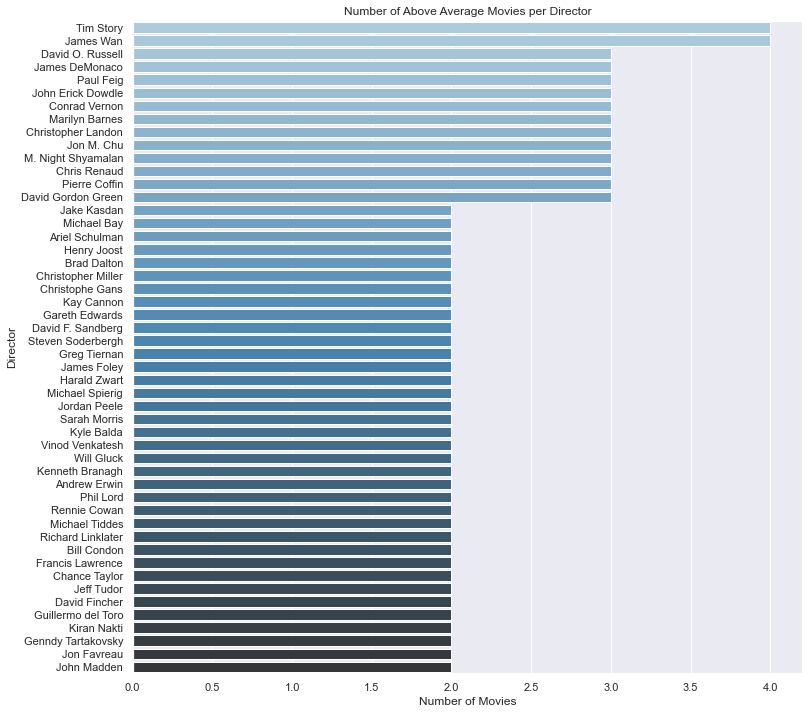

In [359]:
# Plot the 50 most successful names and the number of movies of each director for above average movies.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=aam_directors.values.tolist()[:50], y=aam_directors.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Above Average Movies per Director')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Director');

In [360]:
# Make the same series for actors and actresses.
aam_actor_actress = above_average_movies[(above_average_movies['category'] == 'actor') | \
                           (above_average_movies['category'] == 'actress')]['primary_name'].value_counts()

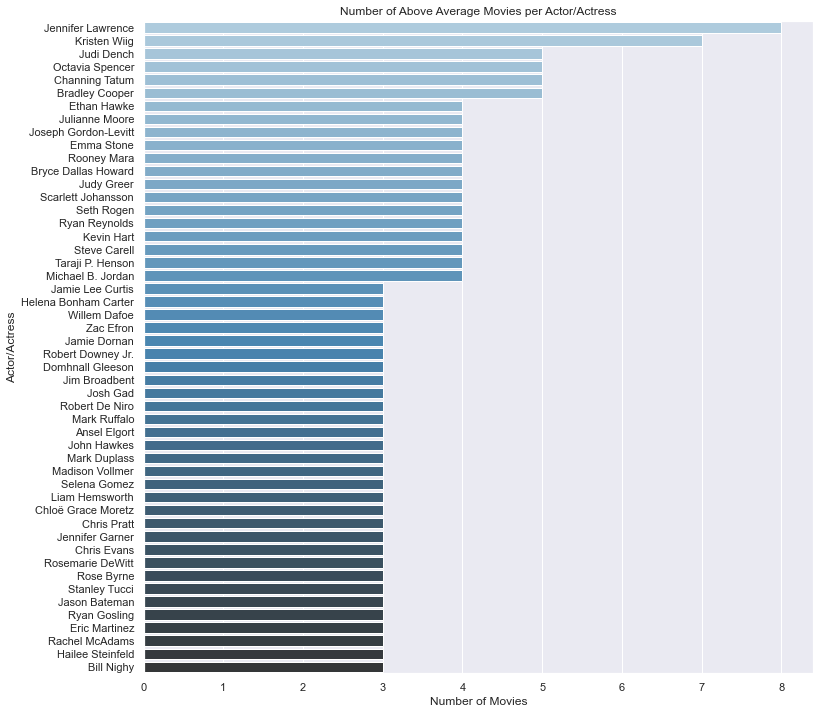

In [361]:
# Make the same plot for actors/actresses.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=aam_actor_actress.values.tolist()[:50], y=aam_actor_actress.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Above Average Movies per Actor/Actress')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actor/Actress');

In [362]:
# Set the standard for poor performance movies at having a high budget and a low ROI.
poor_performance_movies = master_df[(master_df['ROI'] <= money_metrics_df['ROI'].median()) & \
          (master_df['production_budget'] >= money_metrics_df['production_budget'].median())]

In [378]:
poor_performance_movies

,tconst,nconst,category,directors,writers,primary_title,start_year,runtime_minutes,primary_name,primary_profession,...,movie,production_budget,domestic_gross,worldwide_gross,Profit Margin,ROI,Year,Month,averagerating,numvotes
750,tt1124037,nm0217120,cinematographer,nm0002657,"nm0002657,nm0366989",Free State of Jones,2016,139.0,Benoît Delhomme,"cinematographer,camera_department,actor",...,Free State of Jones,50000000.0,20810036.0,23237252.0,-1.151717,0.464745,2016.0,Jun,6.9,45135.0
751,tt1124037,nm0000190,actor,nm0002657,"nm0002657,nm0366989",Free State of Jones,2016,139.0,Matthew McConaughey,"actor,producer,soundtrack",...,Free State of Jones,50000000.0,20810036.0,23237252.0,-1.151717,0.464745,2016.0,Jun,6.9,45135.0
752,tt1124037,nm1813221,actress,nm0002657,"nm0002657,nm0366989",Free State of Jones,2016,139.0,Gugu Mbatha-Raw,"actress,soundtrack",...,Free State of Jones,50000000.0,20810036.0,23237252.0,-1.151717,0.464745,2016.0,Jun,6.9,45135.0
753,tt1124037,nm0991810,actor,nm0002657,"nm0002657,nm0366989",Free State of Jones,2016,139.0,Mahershala Ali,actor,...,Free State of Jones,50000000.0,20810036.0,23237252.0,-1.151717,0.464745,2016.0,Jun,6.9,45135.0
754,tt1124037,nm0005392,actress,nm0002657,"nm0002657,nm0366989",Free State of Jones,2016,139.0,Keri Russell,"actress,soundtrack",...,Free State of Jones,50000000.0,20810036.0,23237252.0,-1.151717,0.464745,2016.0,Jun,6.9,45135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027568,tt7694546,nm9457388,producer,"nm9457390,nm9457387","nm9457387,nm9457390",Beowulf,2018,80.0,Junsheng Liu,producer,...,Beowulf,150000000.0,82280579.0,195080579.0,0.231087,1.300537,2007.0,Nov,NaN,NaN
1028235,tt8450662,nm9856462,director,nm9856462,"nm10664925,nm2826129",Beloved,2018,66.0,Yaser Talebi,"director,cinematographer",...,Beloved,53000000.0,22852487.0,22852487.0,-1.319222,0.431179,1998.0,Oct,7.3,22.0
1028236,tt8450662,nm10664925,writer,nm9856462,"nm10664925,nm2826129",Beloved,2018,66.0,Farzaneh Fathi,writer,...,Beloved,53000000.0,22852487.0,22852487.0,-1.319222,0.431179,1998.0,Oct,7.3,22.0
1028237,tt8450662,nm2826129,writer,nm9856462,"nm10664925,nm2826129",Beloved,2018,66.0,Reza Shirvani,"editor,editorial_department,producer",...,Beloved,53000000.0,22852487.0,22852487.0,-1.319222,0.431179,1998.0,Oct,7.3,22.0


In [364]:
# Take all the directors from the poor performing movies.
ppm_directors = poor_performance_movies[(poor_performance_movies['category'] == 'director')]['primary_name'].value_counts() 

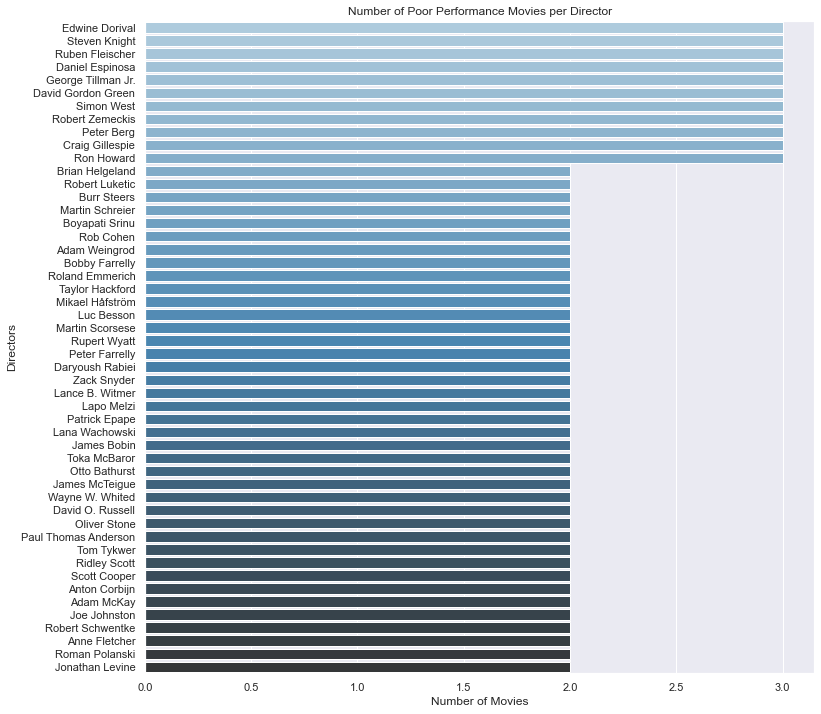

In [365]:
# Plot the 50 least successful names and the number of movies for each director for poor performing movies.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=ppm_directors.values.tolist()[:50], y=ppm_directors.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Poor Performance Movies per Director')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Directors');

In [376]:
# Use ".intersection" to check how many of the successful movie directors, also directed failed movies.
num_dirs_with_good_bad = len(set(ppm_directors.index.tolist()).intersection( aam_directors.index.tolist()))
# Check what percent of good movie directors have also directed bad movies.
per_good_dirs_with_bad = num_dirs_with_good_bad/len(aam_directors)
per_good_dirs_with_bad

0.1150278293135436

We can see that out of all the directors who have directed movies, only 11% of them have also made bad movies.

In [368]:
# Continue the same process for actors/actresses in poor prformance movies.
ppm_actor_actress = poor_performance_movies[(poor_performance_movies['category'] == 'actor') | \
                           (poor_performance_movies['category'] == 'actress')]['primary_name'].value_counts()


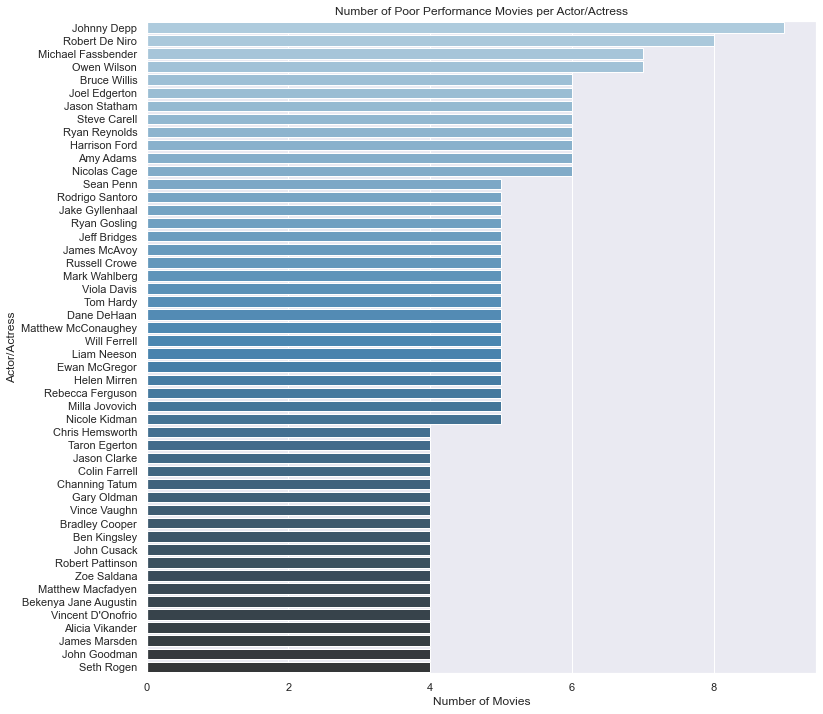

In [369]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=ppm_actor_actress.values.tolist()[:50], y=ppm_actor_actress.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Poor Performance Movies per Actor/Actress')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actor/Actress');

In [377]:
# Use ".intersection" to check how many of the successful movie actors, also acted in failed movies.
num_acts_with_good_bad = len(set(aam_actor_actress.index.tolist()).intersection(ppm_actor_actress.index.tolist()))
# Check what percent of good movie actors have also acted in  bad movies.
per_good_acts_with_bad = num_acts_with_good_bad/len(aam_actor_actress)
per_good_acts_with_bad

0.20186154741128562

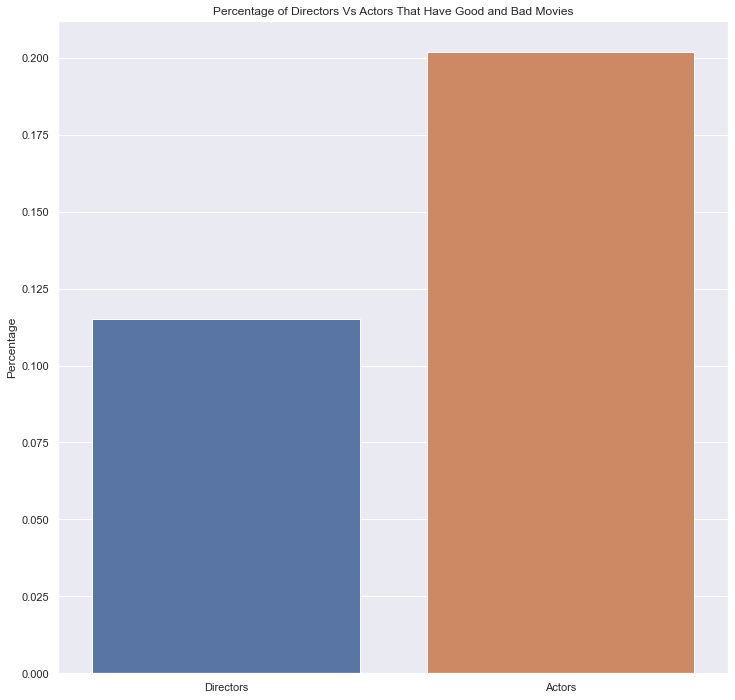

In [375]:
# Plot the difference between the percentages.
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=['Directors', 'Actors'], y=[per_good_dirs_with_bad, per_good_acts_with_bad])
ax.set_title('Percentage of Directors Vs Actors That Have Good and Bad Movies')
ax.set_ylabel('Percentage');

We can conclude from our exploring, that it probably isn't wise to chase after the most expensive actors or actresses. Since we see that many of them who have done really successful movies, have also done that did not do well.
On the other hand for directors, while there is some overlapping, for the most part the succesful movie directors haven't done many bad ones.
The idea that the director is more important than the actors is pretty intuitive. But the data confirms that while directors obviously aren't the only important factor, it is safe to assume that getting a good director is more important than the actors.